In [ ]:
import sys
sys.path.insert(1, '../../eispy2d/library/')

import configuration as cfg
import inputdata as ipt
import result as rst
import draw
import mom_cg_fft as mom

# Parameters
name = 'star'
NM = NS = 80
Ro = 4.
lambda_b = 1.
epsilon_rb = 1.
Lx = Ly = 2.
E0 = 1.
perfect_dielectric = True
resolution = (120, 120)
noise = 5.
indicators = [rst.SHAPE_ERROR, rst.POSITION_ERROR]
epsilon_rd = 1.75
l = 0.9
position = [.0, .0]

config = cfg.Configuration(name=name + '.cfg', number_measurements=NM, 
                           number_sources=NS, observation_radius=Ro, 
                           wavelength=lambda_b,
                           background_permittivity=epsilon_rb,
                           image_size=[Ly, Lx], magnitude=E0,
                           perfect_dielectric=perfect_dielectric)


test = ipt.InputData(name=name + '.ipt', configuration=config, 
                     resolution=resolution, noise=noise, indicators=indicators)

chi = (epsilon_rd-epsilon_rb)/epsilon_rb

test.rel_permittivity, _ = draw.star5(
    l, axis_length_x=Lx, axis_length_y=Ly, resolution=resolution,
    background_rel_permittivity=epsilon_rb, object_rel_permittivity=epsilon_rd,
    center=position, rotate=0.
)

forward = mom.MoM_CG_FFT(tolerance=1e-3, maximum_iterations=5000,
                         parallelization=True)

_ = forward.solve(test)

test.draw(show=True)

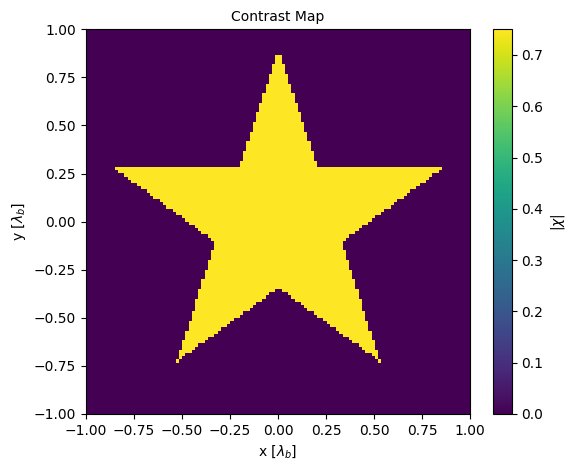

Method: Linear Sampling Method
Alias: lsm
Input Data: star.ipt
Discretization: Richmond Method (40x40)
Regularization Method: Tikhonov
Choice strategy: fixed
Parameter value: 1.000e+01
Field approximation: automatic
Indicator function: standard
Results name: star.ipt_lsm
Configuration: star.cfg
Relative Permit. map resolution: 120x120
Position error: 0.15%
Shape error: 76.99%


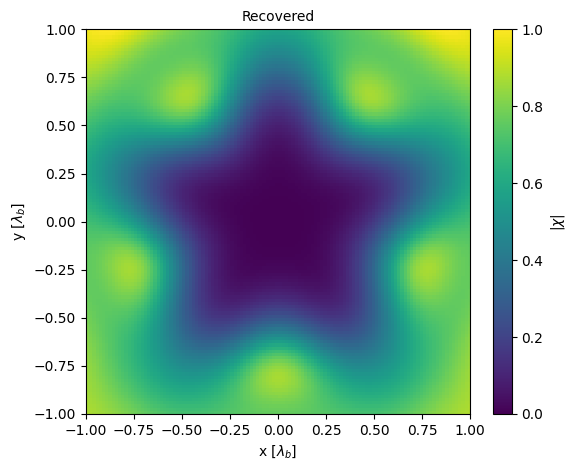

In [ ]:
import stopcriteria as stp
import lsm
import osm
import bim
import csi
import som
import regularization as reg
import richmond as ric

resolution = (40, 40)
discretization = ric.Richmond(configuration=test.configuration,
                              elements=resolution)

regularization = reg.Tikhonov('fixed', parameter=1e0)
LSM = lsm.LinearSamplingMethod(alias='lsm',
                               regularization=regularization, # reg.ConjugatedGradient(10),
                               sv_cutoff=None, threshold=None)
result = LSM.solve(test, discretization)

print(result)
result.plot_map(show=True)

In [ ]:
OSM = osm.OrthogonalitySamplingMethod(threshold=.35)
BIM = bim.BornIterativeMethod(mom.MoM_CG_FFT(), reg.ConjugatedGradient(300), 
                              stp.StopCriteria(max_iterations=30))
CSI = csi.ContrastSourceInversion(stp.StopCriteria(max_iterations=300))
SOM = som.SubspaceBasedOptimizationMethod(stp.StopCriteria(max_iterations=30),
                                          cutoff_index=5)